# The social network of Caesar's *Bellum Gallicum*

## Data Flow

The data will be collected from a reduced version (extracts) of the *Bellum Gallicum*, which has been manually annotated for morphology and syntax according to the Universal Dependency model, in the CoNLL-U format.

See the [GitHub repository](https://github.com/proiel/proiel-treebank/blob/master/caes-gal.conll).

### The components of the CoNLL-U annotation schema

CoNLL-U annotations are distributed as plain text files.

The annotation files contain three types of lines: **comment lines**, **word lines** and **blank lines**.

**Comment lines** precede word lines and start with a hash character (#). These lines can be used to provide metadata about the word lines that follow.

Each **word line** contains annotations for a single word or token. Larger linguistic units are represented by subsequent word lines.

The annotations for a word line are provided using the following fields, each separated by a tabulator character:

```console
ID	FORM	LEMMA	UPOS	XPOS	FEATS	HEAD	DEPREL	DEPS	MISC
```

 1. `ID`: Index of the word in sequence
 2. `FORM`: The form of a word or punctuation symbol
 3. `LEMMA`: Lemma or the base form of a word
 4. `UPOS`: [Universal part-of-speech tag](https://universaldependencies.org/u/pos/)
 5. `XPOS`: Language-specific part-of-speech tag
 6. `FEATS`: [Morphological features](https://universaldependencies.org/u/feat/index.html)
 7. `HEAD`: Syntactic head of the current word
 8. `DEPREL`: Universal dependency relation to the `HEAD`
 9. `DEPS`: [Enhanced dependency relations](https://universaldependencies.org/u/overview/enhanced-syntax.html)
 10. `MISC`: Any additional annotations

Finally, a **blank line** after word lines is used to separate sentences.

For reading and managing the CoNNL-U formatted file, we will use Python [conllu](https://pypi.org/project/conllu/) library.

In [180]:
# Import the conllu library
import conllu
from conllu.models import Token

In [181]:
# Open the plain text file for reading; assign under 'data'
with open('caes_gal.conllu', mode="r", encoding="utf-8") as data:

    # Read the file contents and assign under 'annotations'
    annotations = data.read()
# Use the parse() function to parse the annotations; store under 'sentences'
sentences = conllu.parse(annotations)

The parse() function returns a Python list populated by TokenList objects, native to pyconll library.

In [182]:
# print the first token (TokenList object) of the first sentence (list).
# sentences[0][0]

### Named Entities extraction

First of all, we want to extract the NE from the annotations. Although proper nouns are already marked as such in `annotations`, we don't need to perform an actual NE recognition. Nevertheless, since sentences are annotated token-by-token, in case of multi-token names we need to group the tokens that are associated with the same entity, i.e. are part of the full name of a character. To do so, we can rely on the consistency of the annotation procedure, for which the "second names" are marked as direct dependants of the "first name" token by a 'flat:name' relation.

In [183]:
def get_ne(sentences:list):
    full_names = []
    for sent in sentences:
        visited_tokens = []
        for token in sent:
            if token['xpos'] == 'Ne' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    multi_token_name = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    full_names.append(multi_token_name)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    full_names.append([token])
    return full_names

In [184]:
ne_instances = get_ne(sentences)

In [185]:
ne_tok_instances_set = [l[0] for l in ne_instances]


In [186]:
# ne_tok_instances_set

In [187]:
import itertools
from pprint import pprint
from collections import defaultdict

In [188]:
from pprint import pprint
# pprint(sentences[0].head_to_token(sentences[0]))

In [189]:
def get_relations(sentences:list):

    global_relations = []
    # all_full_names = []
    for sent in sentences:
        relations_in_sentence = []
        entities_in_sent = []
        visited_tokens = []
        for token in sent:
            if token['upos'] == 'PROPN' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    fullname = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    fullname = [token]
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    visited_tokens.append(fullname)

        pairs = list(itertools.combinations(entities_in_sent, 2))

        for pair in pairs:
            ent1 = pair[0]
            ent2 = pair[1]
            value = 1


            if ent1[0]['head'] == ent2[0]['head'] or (ent1[0]['head'] == ent2[0]['id'] or ent2[0]['head'] == ent1[0]['id']):
                value += 2

            if value is not None:
                relation = {'ent1':ent1, 'ent2': ent2, 'value': value}
                relations_in_sentence.append(relation)

        if relations_in_sentence:
            global_relations.append(relations_in_sentence)

    return global_relations

In [190]:
def get_dependency_relations(sentences:list):

    global_relations = []
    # all_full_names = []
    for sent in sentences:

        relations_in_sentence = []
        entities_in_sent = []
        visited_tokens = []
        for token in sent:
            if token['upos'] == 'PROPN' and token not in visited_tokens:
                second_names = [t for t in sent if t['deprel'] == 'flat:name' and t['head'] == token['id'] and t not in visited_tokens]
                visited_tokens.append(token)
                if second_names:
                    fullname = [token, *second_names] # the token corresponding to the "first name" at the beginning of the list
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    for t in second_names:
                        visited_tokens.append(t)
                else:
                    fullname = [token]
                    # all_full_names.append(fullname)
                    entities_in_sent.append(fullname)
                    visited_tokens.append(fullname)

        pairs = list(itertools.combinations(entities_in_sent, 2))

        for pair in pairs:
            ent1 = pair[0]
            ent2 = pair[1]
            value = None

            # if ent1[0]['head']-1 >= 0:
            #     ent1_head_idx = ent1[0]['head']-1
            # else:
            #     sent_root_idx = None
            #     for idx, t in enumerate(range(len(sent))):
            #         if t['deprel'] == 'root':
            #             sent_root_idx = sent[idx]
            #     ent1_head_idx = sent_root_idx
            #
            # if ent2[0]['head']-1 >= 0:
            #     ent2_head_idx = ent2[0]['head']-1
            # else:
            #     sent_root_idx = None
            #     for idx, t in enumerate(range(len(sent))):
            #         if t['deprel'] == 'root':
            #             sent_root_idx = sent[idx]
            #     ent2_head_idx = sent_root_idx

            # -------------------------------------------

            if ent1[0]['head'] == ent2[0]['head']: # same head
                value = 3

            if ent1[0]['head'] == ent2[0]['id'] or ent2[0]['head'] == ent1[0]['id']:
                value = 2

            else:
                try:
                    if ent1[0]['head'] == sent[ent2[0]['head']-1]['head'] or ent2[0]['head'] == sent[ent1[0]['head']-1]['head']:
                        value = 1

                    elif sent[ent1[0]['head']-1]['head'] == sent[ent2[0]['head']-1]['head']: # share grandparent
                        value = 0.5

                except IndexError: # one of the heads is the root
                    value = 0
                    continue


            if value is not None:
                relation = {'ent1':ent1, 'ent2': ent2, 'value': value}
                relations_in_sentence.append(relation)

        if relations_in_sentence:
            global_relations.append(relations_in_sentence)

    return global_relations

In [191]:
relations_instances = get_dependency_relations(sentences)
# relations_instances = get_relations(sentences)

# relations_instances

## Process relations instances

In the script below, the list of relations, in which each entity's occurence is represented by its TokenList object, is processed to obtain a list of tuples, `final_relations`, each of which consists in the weighted edge of the graph that will be built.

In [192]:
tmp_relations = []
for rels_in_sent in relations_instances:

    for rel in rels_in_sent:

        ent1 = ' '.join([i['lemma'] for i in rel['ent1']])
        ent2 = ' '.join([i['lemma'] for i in rel['ent2']])

        value = rel['value']

        row = [ent1, ent2, value]
        tmp_relations.append(row)

# create a defaultdict to store the sums
sums = defaultdict(int)

# loop through the tuples and add the third element to the sum
# for the corresponding first two elements
for t in tmp_relations:
    sums[(t[0], t[1])] += t[2]

# create a new list of tuples with the first two elements as the key
# and the sum as the value
final_relations = [[k[0], k[1], v] for k, v in sums.items()]
final_relations = [rel for rel in final_relations if rel[0] != rel[1]]

In [193]:
# final_relations

#### Create and process the entities that appear in at least one interaction and are actual people

In [194]:
import json

# create list of entities that are involved in a relation
entities = list(sorted({name for rel in final_relations for name in rel if type(name) == str}))

# assign to a variable the list of all places in Latin literature
# places_list = json.loads('places.json')

with open('places.json') as json_file:
   places_list = json.load(json_file)

# filter entities list
people_entities = list(filter(lambda x: x not in places_list, entities))
people_relations = list(filter(lambda x: x[0] not in places_list and x[1] not in places_list, final_relations))


# clean duplicate entities

for idx, item in enumerate(people_relations):
        for i, el in enumerate(item[:2]):
            if 'Cotta' in el:
                item[i] = 'Lucius Aurunculeius Cotta'
                people_relations[idx] = item

for ind, el in enumerate(people_entities):
    if 'Cotta' in el:
                people_entities[ind] = 'Lucius Aurunculeius Cotta'


# Let's build the graph!

In [195]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from pprint import pprint

edges = people_relations
nodes = people_entities

G = nx.Graph()

# for n in nodes:
#     G.add_node(n)

for item in edges:
    G.add_edge(item[0], item[1], weight=item[2])

In [196]:
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())
print('Graph connectedness:' , nx.is_connected(G)) # Graph is not connected! --> implications on betweenness_centrality

Number of nodes:  62
Number of edges:  65
Graph connectedness: False


In [197]:
# print(G.edges().data())

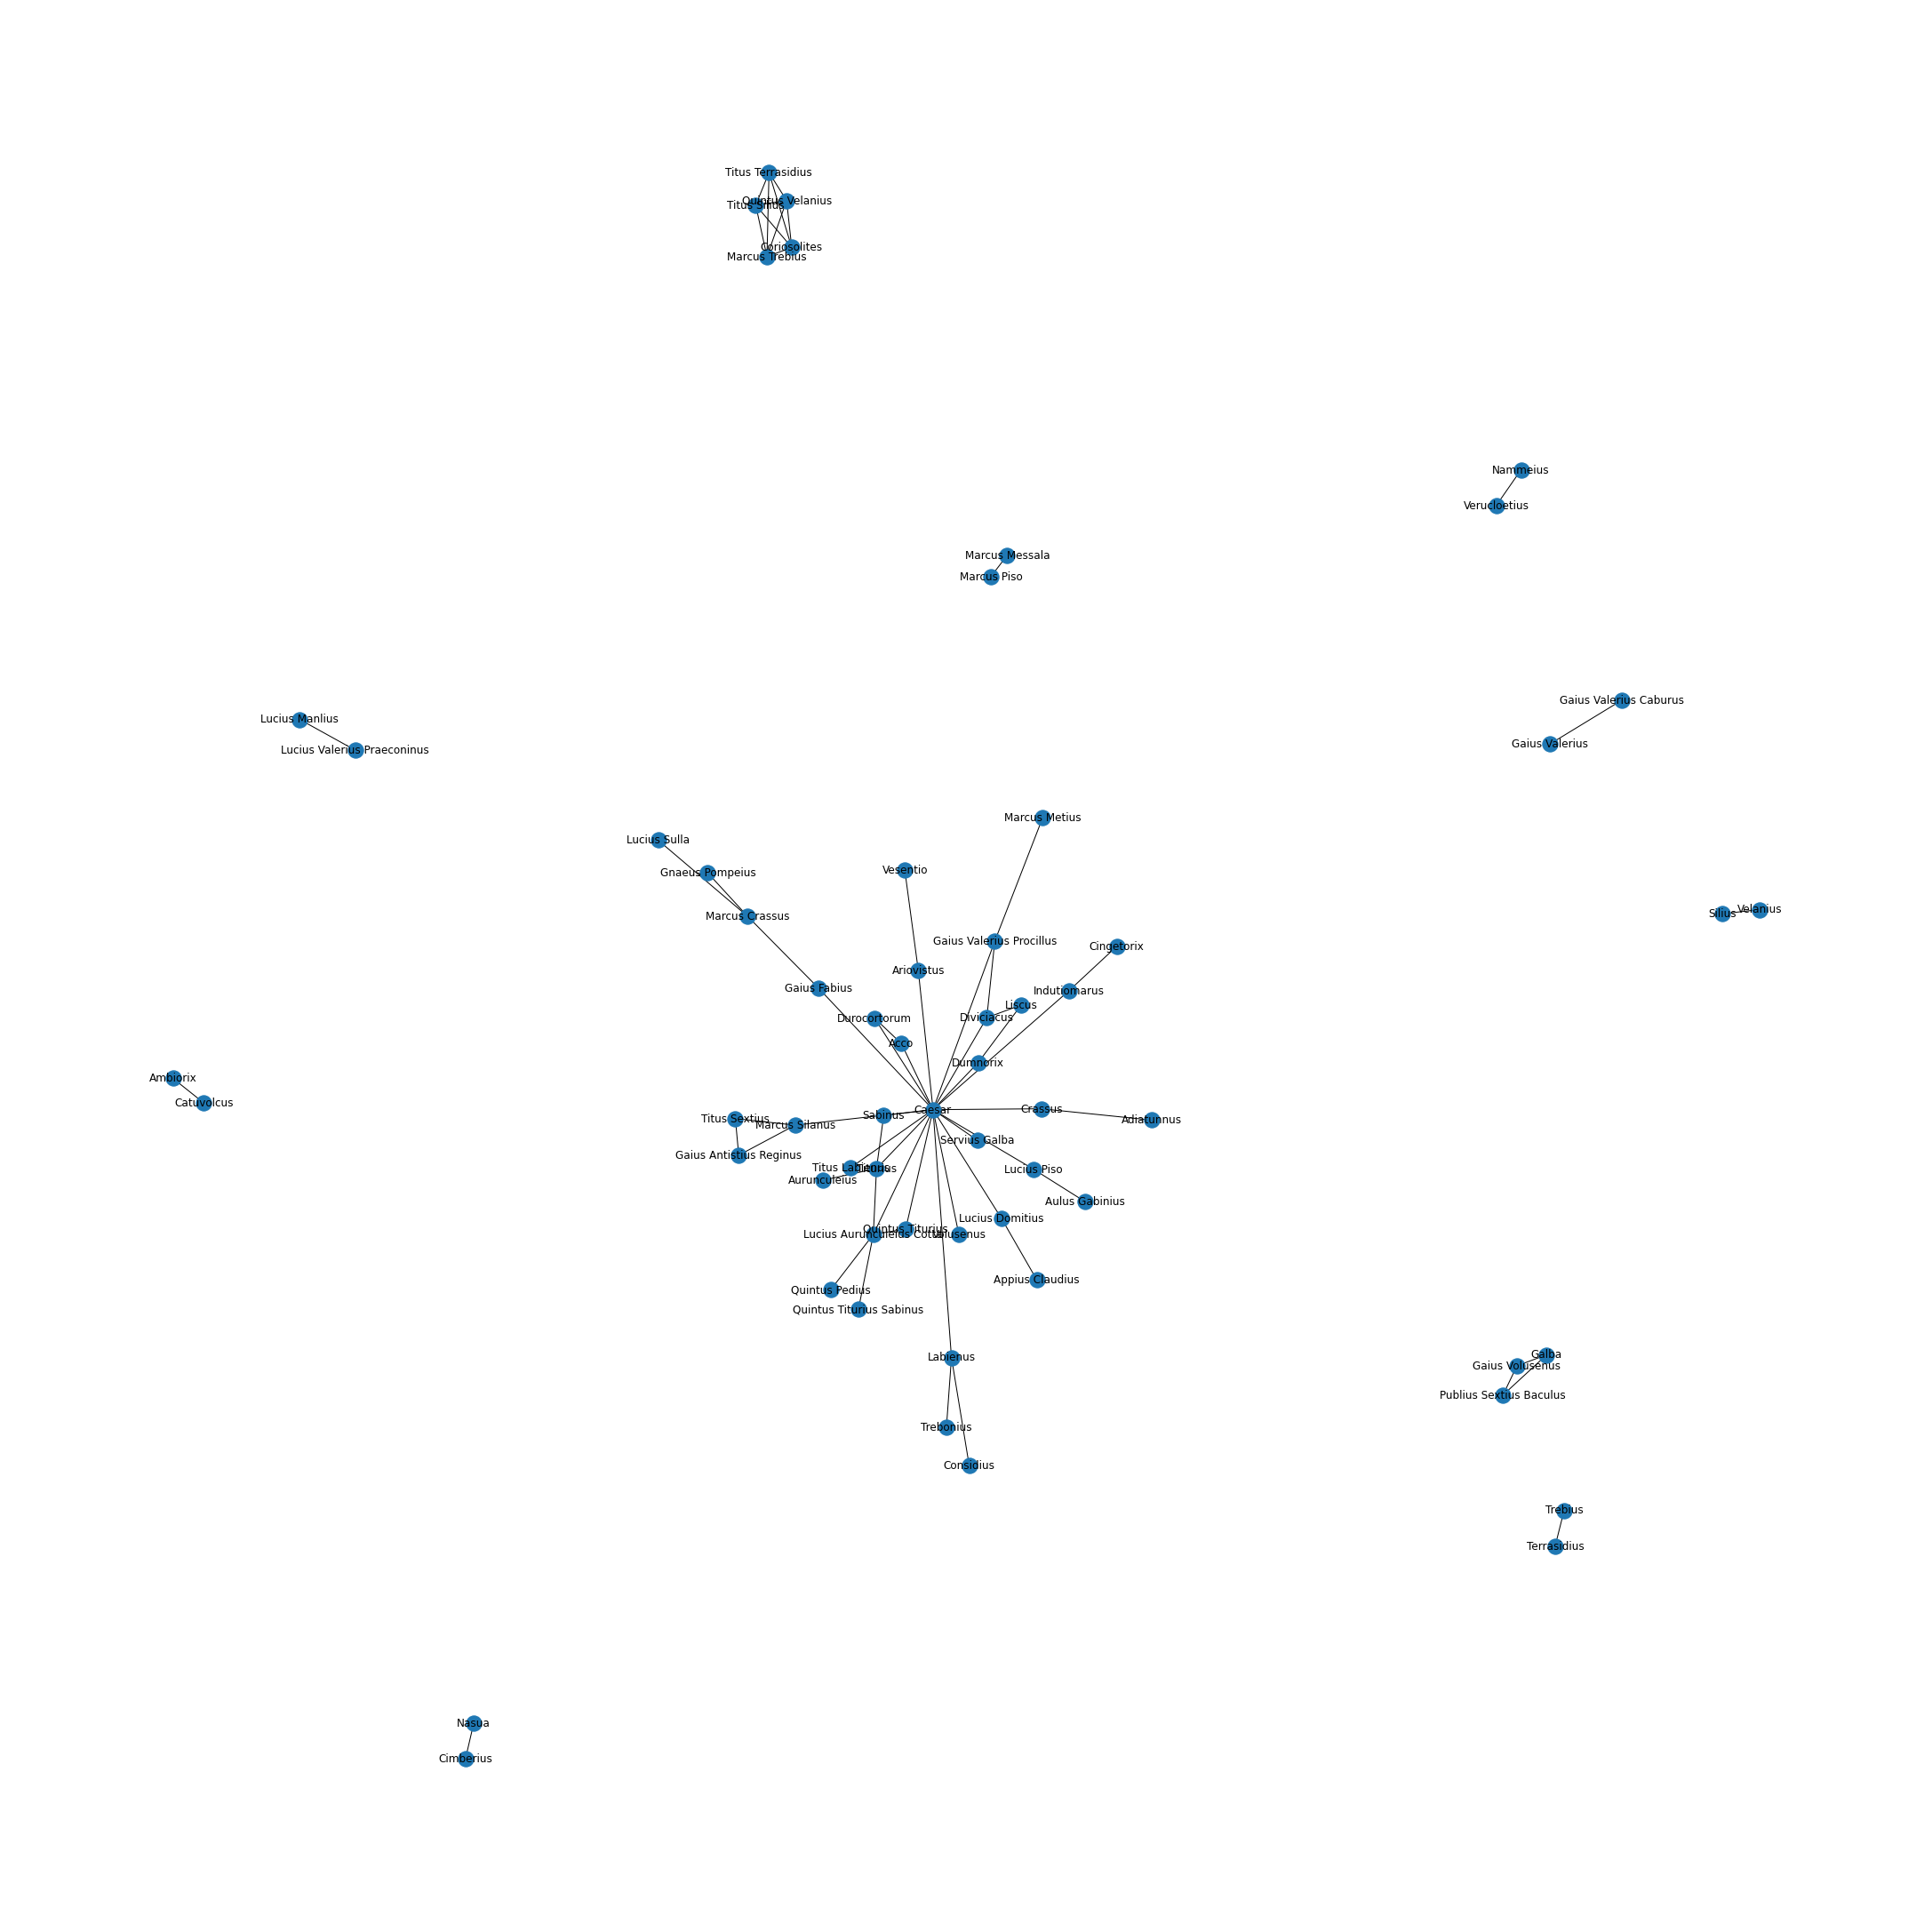

In [198]:
# VISUALIZATION
plt.figure(figsize=(30,30))
nx.draw(G, with_labels=True) # with_labels=True for showing node's label
plt.savefig("graph.png")

# plt.show()

In [199]:
## INTERACTIVE WEB VISUALIZATION

# from pyvis.network import Network
#
# net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color='white')
#
# net.from_nx(G)
# net.show("caes_net.html")

In [200]:
nx.write_gexf(G, "gephi_net.gexf")

In [201]:
dict(nx.degree(G))

{'Marcus Messala': 1,
 'Marcus Piso': 1,
 'Lucius Piso': 2,
 'Aulus Gabinius': 1,
 'Nammeius': 1,
 'Verucloetius': 1,
 'Caesar': 20,
 'Diviciacus': 3,
 'Liscus': 2,
 'Dumnorix': 2,
 'Gaius Valerius Procillus': 3,
 'Lucius Sulla': 1,
 'Marcus Crassus': 3,
 'Labienus': 3,
 'Considius': 1,
 'Nasua': 1,
 'Cimberius': 1,
 'Ariovistus': 2,
 'Vesentio': 1,
 'Marcus Metius': 1,
 'Gaius Valerius Caburus': 1,
 'Gaius Valerius': 1,
 'Titurius': 4,
 'Quintus Pedius': 1,
 'Lucius Aurunculeius Cotta': 5,
 'Servius Galba': 1,
 'Publius Sextius Baculus': 2,
 'Gaius Volusenus': 2,
 'Galba': 2,
 'Titus Terrasidius': 4,
 'Marcus Trebius': 4,
 'Coriosolites': 4,
 'Quintus Velanius': 4,
 'Titus Silius': 4,
 'Silius': 1,
 'Velanius': 1,
 'Trebius': 1,
 'Terrasidius': 1,
 'Crassus': 2,
 'Sabinus': 2,
 'Lucius Valerius Praeconinus': 1,
 'Lucius Manlius': 1,
 'Adiatunnus': 1,
 'Gnaeus Pompeius': 1,
 'Volusenus': 1,
 'Quintus Titurius Sabinus': 1,
 'Titus Labienus': 1,
 'Quintus Titurius': 2,
 'Lucius Domitius'

In [202]:
degrees = nx.degree(G) # high number of interactions for important nodes
degree_centrality = nx.degree_centrality(G) # more interactions for important nodes
betweenness_centrality = nx.betweenness_centrality(G) # more power in passing information (computed only for the big component when graph is not connected)
closeness_centrality = nx.closeness_centrality(G) # easy communication of important nodes (not suitable for disconnected graphs)
harmonic_centrality = nx.harmonic_centrality(G) # alternative to closeness centrality for disconnected graphs
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')
density = nx.density(G)
# diameter = nx.diameter() # not possible, since the graph is disconnected https://stackoverflow.com/a/69636529/20184608
clustering_coefficient = nx.clustering(G, weight='weight') # not used

In [203]:
## DEGREE
# print(sorted(degrees, key=lambda x: x[1], reverse=True))

In [204]:
# # DEGREE CENTRALITY
# print(sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True))

In [205]:
# # CLOSENESS CENTRALITY
# print(sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True))

In [206]:
# # HARMONIC CENTRALITY
# print(sorted(harmonic_centrality.items(), key=lambda x:x[1], reverse=True))

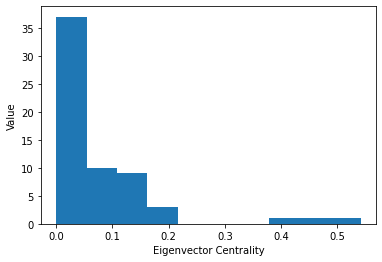

In [207]:
# Extract the betweenness centrality values from the dictionary
# betweenness_centrality_values = list(betweenness_centrality.values())

# Create a histogram of the betweenness centrality values
plt.hist(list(eigenvector_centrality.values()),
         )
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Value')
plt.savefig("out/eigenvector.png")
# plt.savefig("out/betweenness_centrality_hist.svg")
plt.show()

##### Eigenvector centrality
The value of the Eigenvector centrality (centrality of a node based on the centrality of its neighbors) of each node can be interpreted as a measure of how “important” is each individual, since we would expect that “important” individuals (such as Caesar and other Roman generals) interact more frequently with other important individuals than they do with “minor” actors

In [208]:
# EIGENVECTOR CENTRALITY
# print(sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True))

##### Betweenness centrality and centralization
We compute betweennes centrality and see if a small number of nodes have much higher degree centrality values than the others. The betweenness centrality computation is weighted and performed considering only on the biggest component (since the graph is not connected).

In [209]:
## BETWEENNESS CENTRALITY
# print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True))

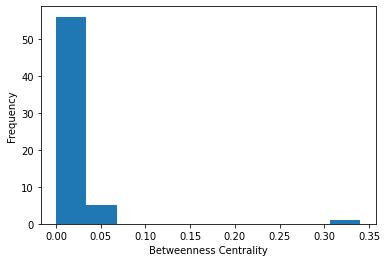

In [210]:
# Extract the betweenness centrality values from the dictionary
betweenness_centrality_values = list(betweenness_centrality.values())

# Create a histogram of the betweenness centrality values
plt.hist(betweenness_centrality_values)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.savefig("out/betweenness_centrality_hist.png")
plt.savefig("out/betweenness_centrality_hist.svg")
plt.show()

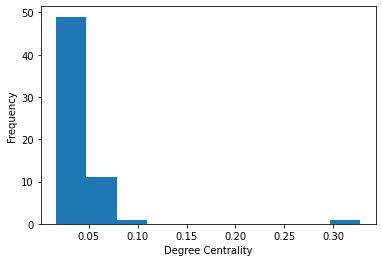

In [211]:

# Create a histogram of the degree centrality values
plt.hist(list(degree_centrality.values()))
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.savefig("out/degree_centrality_hist.png")
plt.show()

In [212]:
## CLUSTERING COEFFICIENT
# print(sorted(clustering_coefficient.items(), key=lambda x:x[1], reverse=True))


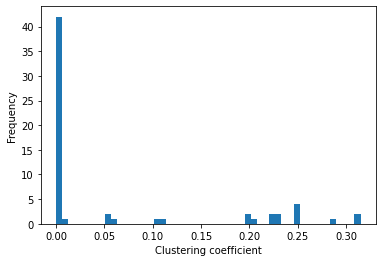

In [213]:
plt.hist(clustering_coefficient.values(), bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.savefig("out/clustering_coefficient.png")
plt.savefig("out/clustering_coefficient.svg")
plt.show()

In [214]:
import pandas as pd

adj_matrix = nx.adjacency_matrix(G)
adj_matrix_df = pd.DataFrame.sparse.from_spmatrix(adj_matrix)

C:\Users\media\AppData\Local\Temp/ipykernel_27428/2379880176.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


In [215]:
# Caesar = nx.ego_graph(G, 'Caesar')
# # VISUALIZATION
# plt.figure(figsize=(15,15))
# nx.draw(Caesar, with_labels=True) # with_labels=True for showing node's label
# print(nx.number_of_nodes(Caesar))
# plt.show()

In [216]:
core_k_by_node = nx.core_number(G)
core_k_by_node # max number of k for each node, ie the number of nodes each node can be connected to so that all the nodes in that core are connected

{'Marcus Messala': 1,
 'Marcus Piso': 1,
 'Lucius Piso': 1,
 'Aulus Gabinius': 1,
 'Nammeius': 1,
 'Verucloetius': 1,
 'Caesar': 2,
 'Diviciacus': 2,
 'Liscus': 2,
 'Dumnorix': 2,
 'Gaius Valerius Procillus': 2,
 'Lucius Sulla': 1,
 'Marcus Crassus': 1,
 'Labienus': 1,
 'Considius': 1,
 'Nasua': 1,
 'Cimberius': 1,
 'Ariovistus': 1,
 'Vesentio': 1,
 'Marcus Metius': 1,
 'Gaius Valerius Caburus': 1,
 'Gaius Valerius': 1,
 'Titurius': 2,
 'Quintus Pedius': 1,
 'Lucius Aurunculeius Cotta': 2,
 'Servius Galba': 1,
 'Publius Sextius Baculus': 2,
 'Gaius Volusenus': 2,
 'Galba': 2,
 'Titus Terrasidius': 4,
 'Marcus Trebius': 4,
 'Coriosolites': 4,
 'Quintus Velanius': 4,
 'Titus Silius': 4,
 'Silius': 1,
 'Velanius': 1,
 'Trebius': 1,
 'Terrasidius': 1,
 'Crassus': 1,
 'Sabinus': 2,
 'Lucius Valerius Praeconinus': 1,
 'Lucius Manlius': 1,
 'Adiatunnus': 1,
 'Gnaeus Pompeius': 1,
 'Volusenus': 1,
 'Quintus Titurius Sabinus': 1,
 'Titus Labienus': 1,
 'Quintus Titurius': 2,
 'Lucius Domitius':

#### K-cores

In order to indentify relevant set of nodes, k_cores are looked for in the graph. From computing `nx.core_number(G)`, we see that the great majority of nodes have core number 1 (the core number of a node is the largest value k of a k-core containing that node), therefore we expect the subgraph for k=2 to be substantially different from the original one.

For k=2, the Caesar's node is still in the (sub)graph, while for k>=3, only one core remains. This decomposition of the graph in cores could be used to identiy the core-periphery structure of the network, where the nodes "remaining" in the graph at the highest value of k would be the central "core" of the network, and the ones removed the periphery. The disconnectedness of graph, though, makes this interpretation deceiving: the remaining core is definitely less relevant for the whole network than the bigger cores we find at k=2.

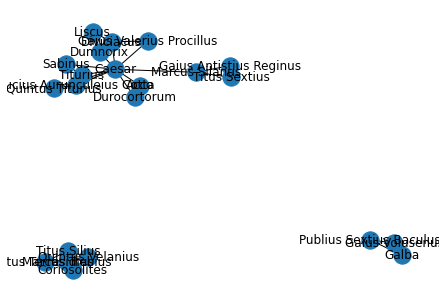

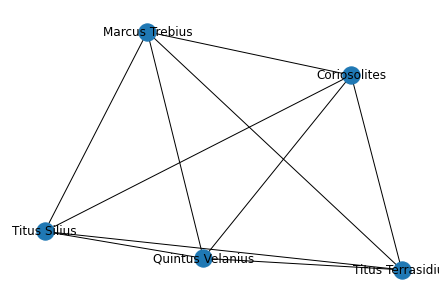

In [217]:
k2_core_subgraph = G.subgraph(nx.k_core(G, k=2))
k3_core_subgraph = G.subgraph(nx.k_core(G, k=3))

nx.draw(k2_core_subgraph, with_labels=True) # 2-cores subgraph
plt.show()

nx.draw(k3_core_subgraph, with_labels=True) # 3-cores subgraph
plt.show()


In [218]:
len(nx.k_core(G, k=2))

22

In [219]:
avg_clustering_coefficient = nx.average_clustering(G)

In [220]:
# avg_clustering_coefficient

#### Cliques

In [221]:
cliques_list = sorted(list(nx.enumerate_all_cliques(G)), key=lambda x:len(x), reverse=True)
cliques_list
# nx.find_cliques
# len(cliques_list)

nx.find_cliques(G)
print(len([x for x in cliques_list if 'Caesar' not in x]))
print(len([x for x in cliques_list if len(x) > 2]))
print(len([x for x in cliques_list if len(x) > 2 and 'Caesar' not in x]))


In [222]:
clique_subgraph = G.subgraph(nx.find_cliques(G))

nx.draw(clique_subgraph, with_labels=True) # 2-cores subgraph
plt.show()


In [ ]:
# nx.clustering(G)

In [ ]:
import pandas as pd
import dataframe_image as dfi


# degrees = nx.degree(G) # high number of interactions for important nodes
# degree_centrality = nx.degree_centrality(G) # more interactions for important nodes
# betweenness_centrality = nx.betweenness_centrality(G) # more power in passing information (computed only for the big component when graph is not connected)
# closeness_centrality = nx.closeness_centrality(G) # easy communication of important nodes (not suitable for disconnected graphs)
# harmonic_centrality = nx.harmonic_centrality(G) # alternative to closeness centrality for disconnected graphs
# eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')

degrees = dict(degrees)


# Create an empty DataFrame with the shared keys as the index
# and the dictionaries' keys as the column names
df = pd.DataFrame(index=list(degrees.keys()))
df['Degree'] = None
df['Degree c.'] = None
df['Betweenness c.'] = None
df['Closeness c.'] = None
df['Harmonic c.'] = None
df['Eigenvector c.'] = None

# Fill the DataFrame with the values from the dictionaries
for key, value in degrees.items():
    df.at[key, 'Degree'] = value
for key, value in degree_centrality.items():
    df.at[key, 'Degree c.'] = value
for key, value in betweenness_centrality.items():
    df.at[key, 'Betweenness c.'] = value
for key, value in closeness_centrality.items():
    df.at[key, 'Closeness c.'] = value
for key, value in harmonic_centrality.items():
    df.at[key, 'Harmonic c.'] = value
for key, value in eigenvector_centrality.items():
    df.at[key, 'Eigenvector c.'] = value

df.sort_values(by=list(df.columns), ascending=False, inplace=True)

df.to_csv('out/centrality_measures.csv', sep='\t', index=False)

df_styled = df.style.background_gradient()
dfi.export(df,"out/centrality_measures.png")
df

In [ ]:
## DEGREE HISTOGRAM

plt.hist(list(dict(nx.degree(G)).values()))
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('out/network_degree.png') #Save as file, format specified in argument
